# Starbucks Capstone Challenge
## EDA

In [78]:
import base64
import os
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import robust_scale, quantile_transform

In [79]:


def convert_fig_to_html(figure):
    """
    Convert a given matplotlib figure to HTML code
    
    Attributes:
    figure (matplotlib.figure.Figure): Generated without using pyplot.
    
    Return:
    return: img-html tag containing the figure data
    """
    # Save figure to a temporary buffer
    buf = BytesIO()
    figure.savefig(buf, format="png")
    # Embed the result in the html output
    data = base64.b64encode(buf.getbuffer()).decode("ascii")
    return f'<img src="data:image/png;base64,{data}" ' \
            'style="display:inline;top:0%"/>'

## Portfolio

In [80]:
portfolio_df = pd.read_json('data/portfolio.json', orient='records', lines=True)
display(portfolio_df)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


There are three types of offers: buy-one-get-one (BOGO), discount, and informational:
* BOGO: a user needs to spend a certain amount to get a reward equal to that threshold amount.  
* Discount: a user gains a reward equal to a fraction of the amount spent.  
* Informational: no reward, no requisite amount that the user is expected to spend.

Offers can be delivered via multiple channels:
* email
* social media
* on the web
* via the Starbucks’s app.

Every offer has a validity period (*duration*) before the offer expires.  

In [81]:
print(f'Missing data:\n{portfolio_df.isna().any()}')

Missing data:
reward        False
channels      False
difficulty    False
duration      False
offer_type    False
id            False
dtype: bool


In [82]:
display(pd.DataFrame(portfolio_df.describe()))

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


Features *reward*, *difficulty*, and *duration*  values in different ranges, so I have to scale them to the same range.

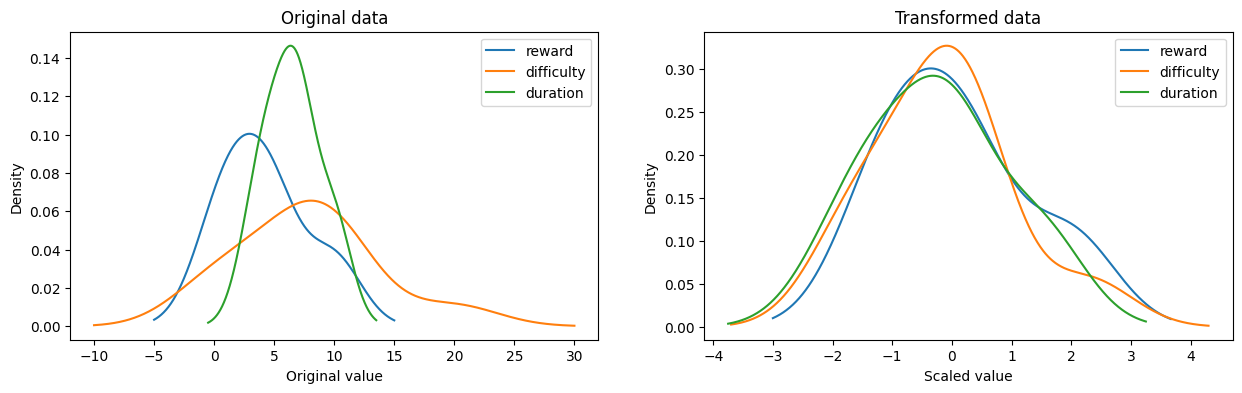

In [83]:
fig, axs = plt.subplots(figsize=(15,4), nrows=1, ncols=2)

rdd_df = portfolio_df[['reward','difficulty','duration']]
rdd_df.plot.density(ax=axs[0])
axs[0].set_title('Original data')
axs[0].set_xlabel('Original value')

data_transformed = robust_scale(rdd_df)
rdd_df = pd.DataFrame(data_transformed, columns=rdd_df.columns, index=rdd_df.index)

rdd_df.plot.density(ax=axs[1])
axs[1].set_title('Transformed data')
axs[1].set_xlabel('Scaled value')

plt.savefig('figures/portfolio_rescale.png', bbox_inches='tight')
plt.show()

# Profile

In [84]:
profile_df = pd.read_json('data/profile.json', orient='records', lines=True)
display(profile_df.head())

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


### Analyzing the missing values
There are empty values in columns **income** and **gender**, and abnormal value 118 in column **age**.  
It is necessary to verify if these issues are in the same row.

In [85]:
print('Counting not null features')
display(pd.DataFrame(profile_df.count())) 

Counting not null features


,0
gender,14825
age,17000
id,17000
became_member_on,17000
income,14825


In [86]:
print('Dataframe description')
display(profile_df.describe())

Dataframe description


,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [87]:
print('Gender by user')
display(pd.DataFrame(profile_df.gender.value_counts()))

Gender by user


,count
gender,
M,8484
F,6129
O,212


In [88]:
gender_isna = profile_df.gender.isna()
income_isna = profile_df.income.isna()
age_missing = profile_df.age == 118

print('Gender:\tnumber of NA:', gender_isna.sum())
print('Income:\tnumber of NA:', income_isna.sum())
print('Age:\tmissing values:', age_missing.sum())

print(f'\nGender and income missing in the same rows?: {gender_isna.isin(income_isna).all()}')
print(f'Gender and age missing in the same rows?: {gender_isna.isin(age_missing).all()}')
print(f'Income and age missing in the same rows?: {income_isna.isin(age_missing).all()}')

Gender:	number of NA: 2175
Income:	number of NA: 2175
Age:	missing values: 2175

Gender and income missing in the same rows?: True
Gender and age missing in the same rows?: True
Income and age missing in the same rows?: True


All the missing values occur in the same rows.  

### Explore ages

/tmp/ipykernel_25909/2160633284.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels((axs[0].get_yticks()*100).round(0))


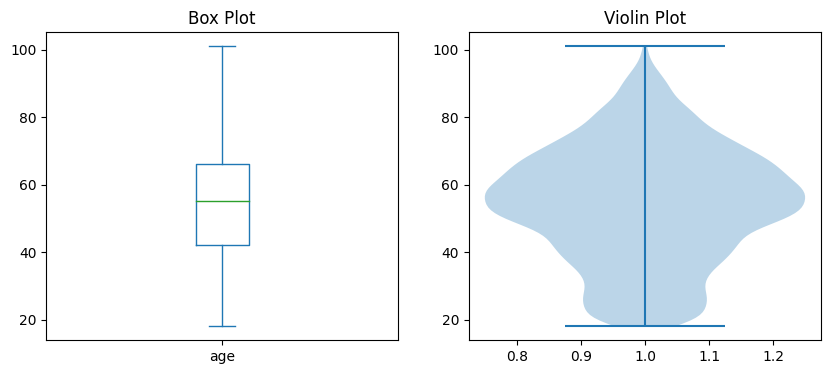

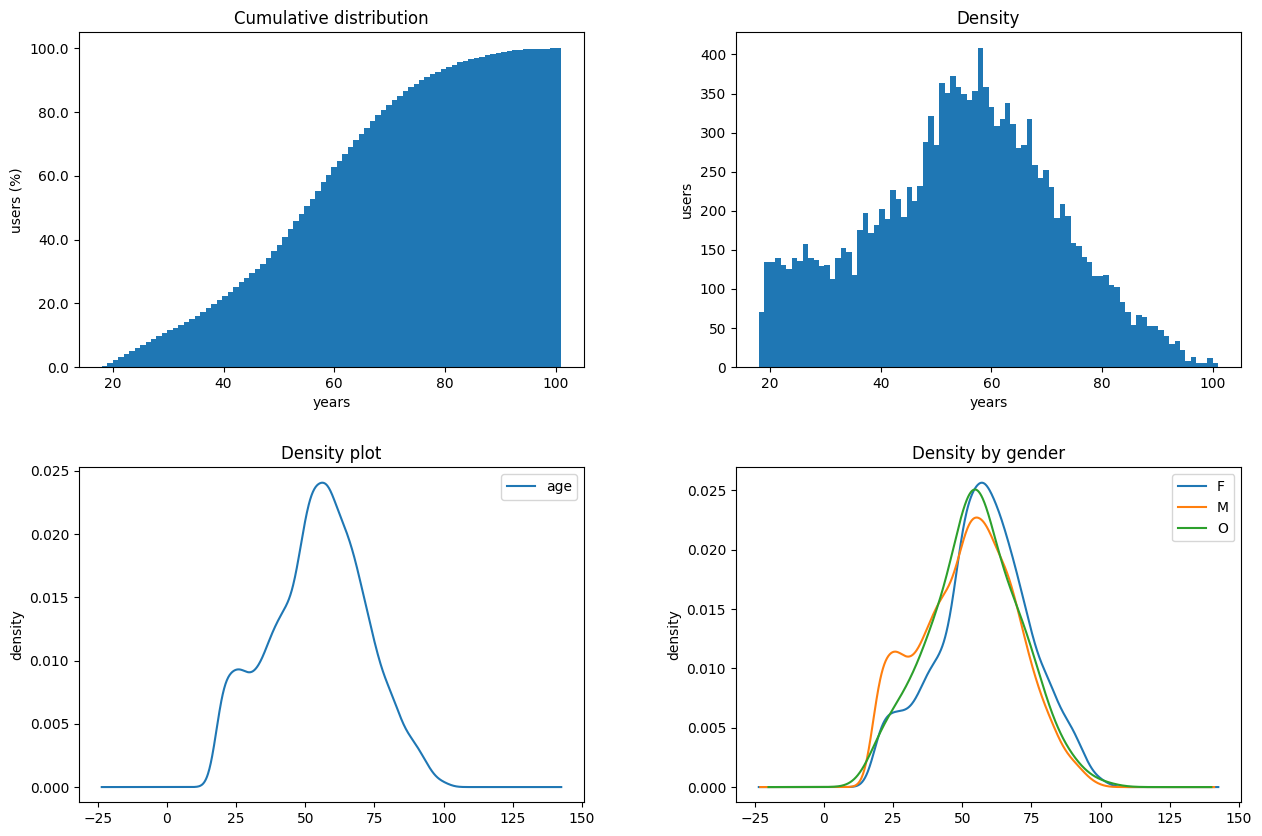

In [90]:
## Select registers with valid age
age_df = pd.DataFrame(profile_df.age[~age_missing])

## Generate box and violin plots
fig1 = plt.figure(figsize=(10,4))
axs = fig1.subplots(nrows=1, ncols=2)
axs = axs.flatten()
axs[0].set_title('Box Plot')
age_df.plot.box(ax=axs[0])
axs[1].violinplot(age_df.values)
axs[1].set_title('Violin Plot')
plt.savefig('figures/explore_age1.png', bbox_inches='tight')

## Generate histograms
bins = 84
fig2, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axs = axs.flatten()

# Cumulative distribution
age_df.hist(bins=bins, ax=axs[0], cumulative=True, density=True)
axs[0].set_title('Cumulative distribution')
axs[0].set_ylabel('users (%)')
axs[0].set_yticklabels((axs[0].get_yticks()*100).round(0))
axs[0].set_xscale('linear')
axs[0].set_xlabel('years')
axs[0].grid(False)

# Histogram
age_df.hist(bins=bins, ax=axs[1])
axs[1].set_title('Density')
axs[1].set_ylabel('users')
axs[1].set_xscale('linear')
axs[1].set_xlabel('years')
axs[1].grid(False)

# density
age_df.plot.density(ax=axs[2])
axs[2].legend()
axs[2].set_title('Density plot')
axs[2].set_ylabel('density')
axs[2].grid(False)

age_gender_df = profile_df[~age_missing].groupby('gender').age
age_gender_df.plot.density(ax=axs[3])
axs[3].set_title('Density by gender')
axs[3].set_ylabel('density')
axs[3].legend()
axs[3].grid(False)

plt.savefig('figures/explore_age2.png', bbox_inches='tight')
plt.show()

The age is normally distributed among the population, so simple standardization is enough.

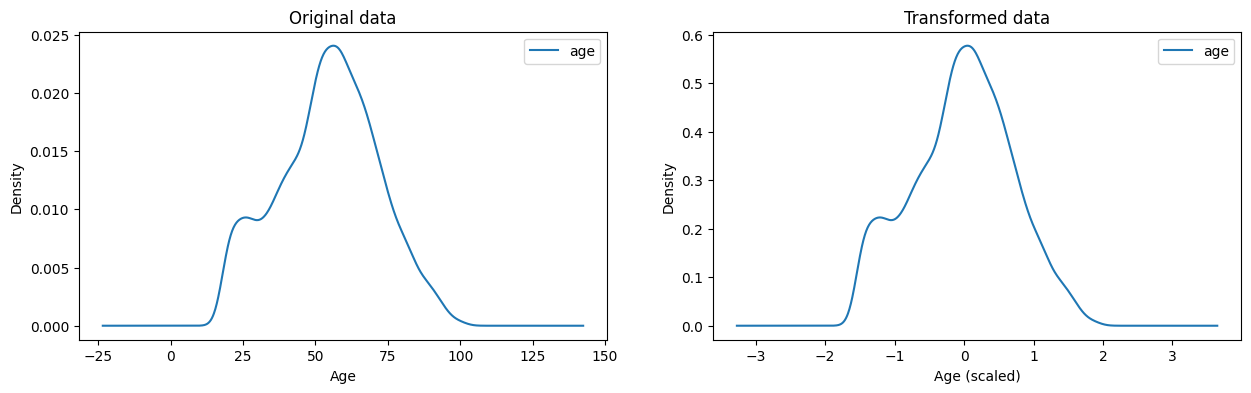

In [91]:
fig, axs = plt.subplots(figsize=(15,4), nrows=1, ncols=2)

age_df.plot.density(ax=axs[0])
axs[0].set_title('Original data')
axs[0].set_xlabel('Age')

data_transformed = robust_scale(age_df)
age_df = pd.DataFrame(data_transformed, columns=age_df.columns, index=age_df.index)

age_df.plot.density(ax=axs[1])
axs[1].set_title('Transformed data')
axs[1].set_xlabel('Age (scaled)')

plt.savefig('figures/age_rescale.png', bbox_inches='tight')
plt.show()

### Explore income

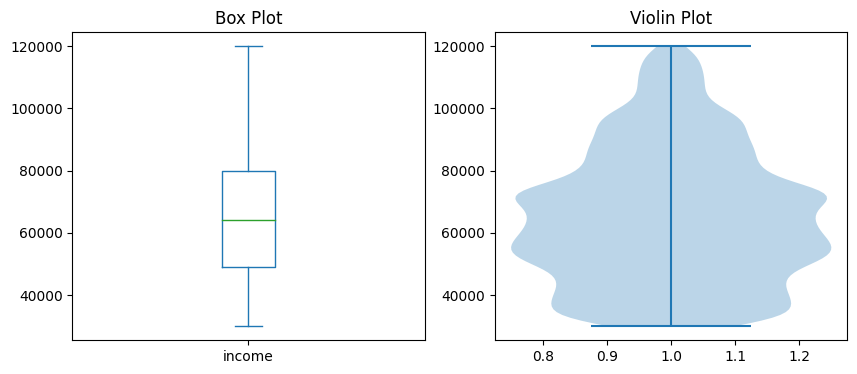

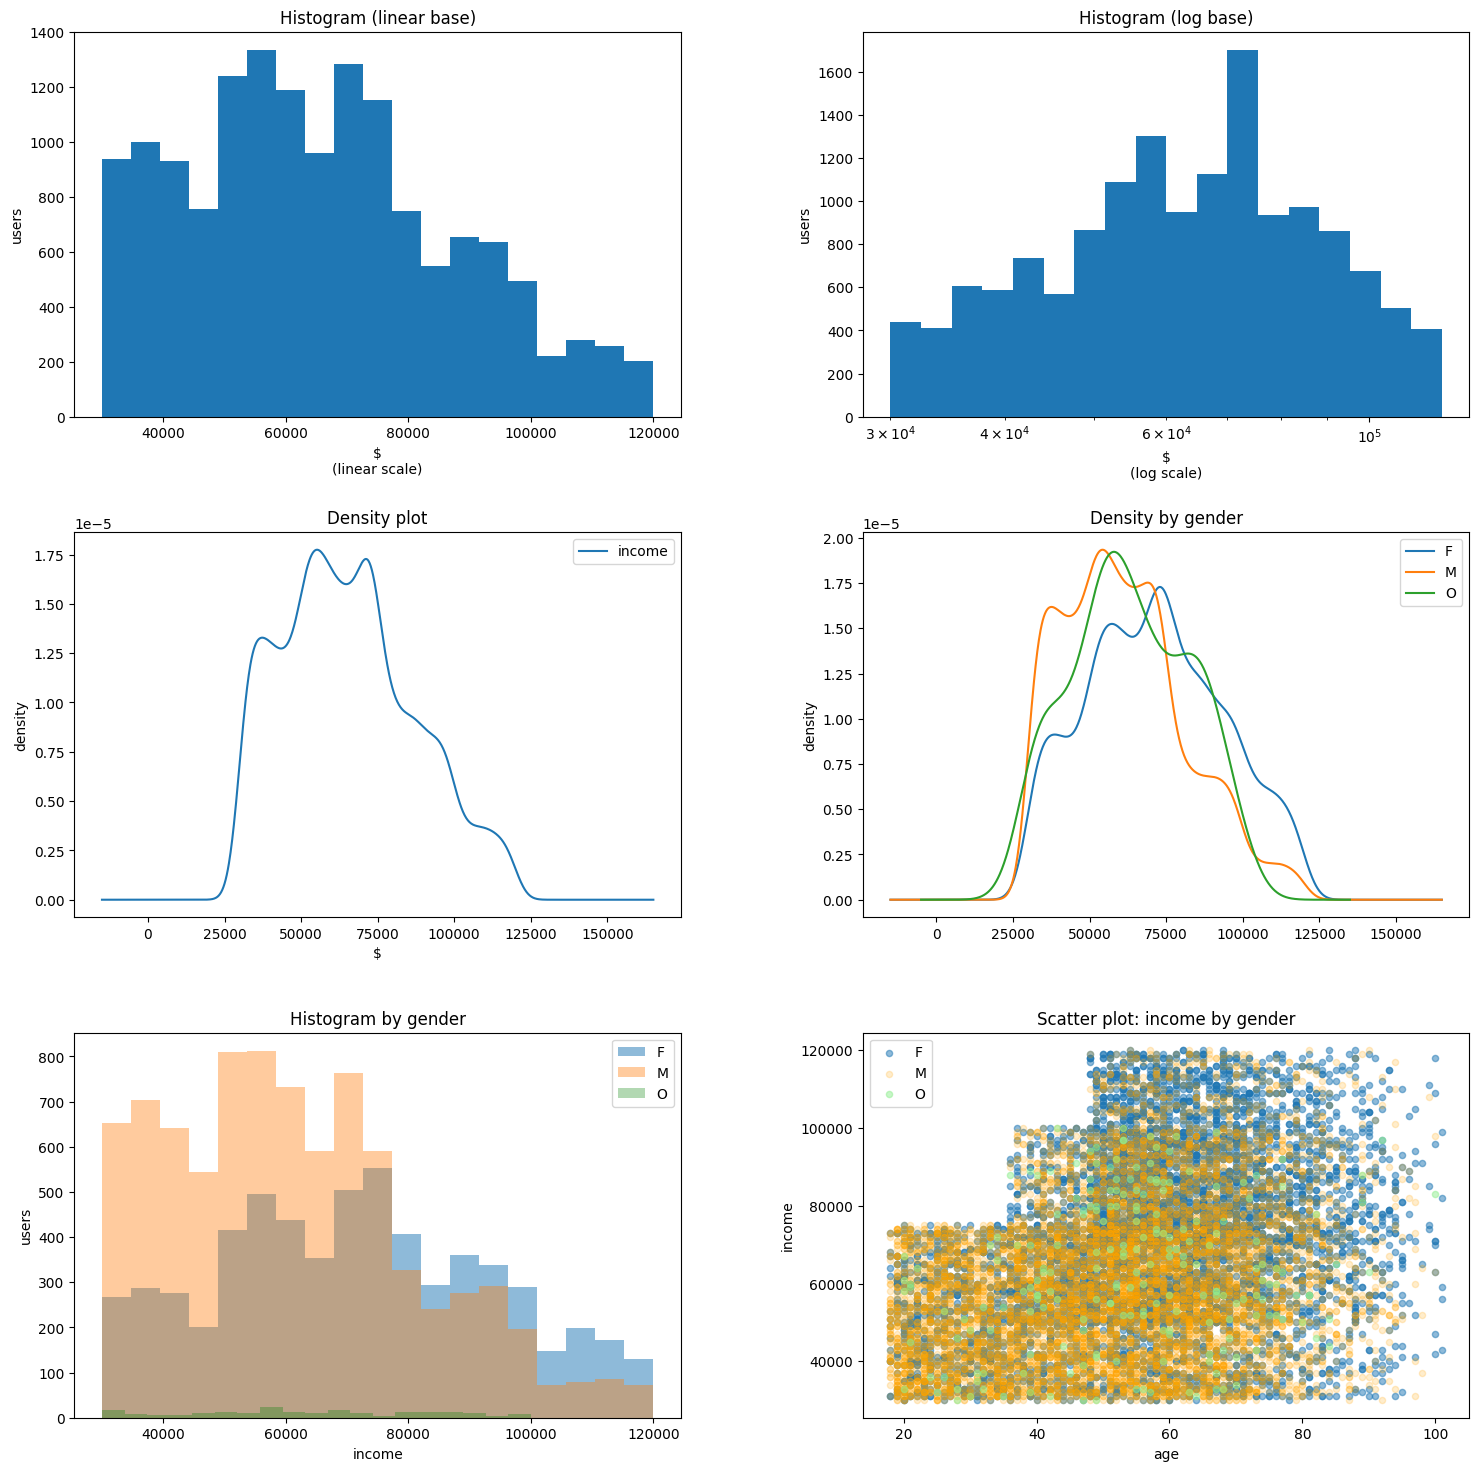

In [92]:
## Select registers with valid income
income_df = pd.DataFrame(profile_df.income[~income_isna])

## Generate box and violin plots
fig1 = plt.figure(figsize=(10,4))
axs = fig1.subplots(nrows=1, ncols=2)
axs = axs.flatten()
axs[0].set_title('Box Plot')
income_df.plot.box(ax=axs[0])
axs[1].violinplot(income_df.values)
axs[1].set_title('Violin Plot')
plt.savefig('figures/explore_income1.png', bbox_inches='tight')

## Generate histograms
bins = 19
logbins = np.logspace(np.log10(income_df.min().min()),
                      np.log10(income_df.max().max()),
                      num=bins)
fig2, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))
axs = axs.flatten()

# linear scale
income_df.hist(bins=bins, ax=axs[0])
axs[0].set_title('Histogram (linear base)')
axs[0].set_ylabel('users')
axs[0].set_xscale('linear')
axs[0].set_xlabel('$\n(linear scale)')
axs[0].grid(False)

# log scale
income_df.hist(bins=logbins, ax=axs[1])
axs[1].set_title('Histogram (log base)')
axs[1].set_ylabel('users')
axs[1].set_xscale('log')
axs[1].set_xlabel('$\n(log scale)')
axs[1].grid(False)

# density
income_df.plot.density(ax=axs[2])
axs[2].set_title('Density plot')
axs[2].set_ylabel('density')
axs[2].set_xlabel('$')
axs[2].grid(False)

# Group income by gender
income_gender_df = profile_df[~income_isna].groupby('gender')
income_gender_df.income.plot.density(ax=axs[3])
axs[3].set_title('Density by gender')
axs[3].set_ylabel('density')
axs[3].legend()
axs[3].grid(False)

income_gender_df.get_group('F') \
    .income.hist(bins=bins, ax=axs[4], alpha=0.5, label='F')
income_gender_df.get_group('F') \
    .plot.scatter(x='age', y='income', ax=axs[5], alpha=0.5, label='F')

income_gender_df.get_group('M') \
    .income.hist(bins=bins, ax=axs[4], alpha=0.4, label='M')
income_gender_df.get_group('M') \
    .plot.scatter(x='age', y='income', c='orange',
                  ax=axs[5], alpha=0.2, label='M')

income_gender_df.get_group('O') \
    .income.hist(bins=bins, ax=axs[4], color='green', alpha=0.3, label='O')
income_gender_df.get_group('O') \
    .plot.scatter(x='age', y='income', c='lightgreen',
                  ax=axs[5], alpha=0.5, label='O')

axs[4].set_title('Histogram by gender')
axs[4].set_ylabel('users')
axs[4].set_xlabel('income')
axs[4].legend()
axs[4].grid(False)
axs[5].set_title('Scatter plot: income by gender')
axs[5].legend()
axs[5].grid(False)

plt.savefig('figures/explore_income2.png', bbox_inches='tight')
plt.show()

Income is not well distributed.  
There is a strong correlation between some ranges of age and income.

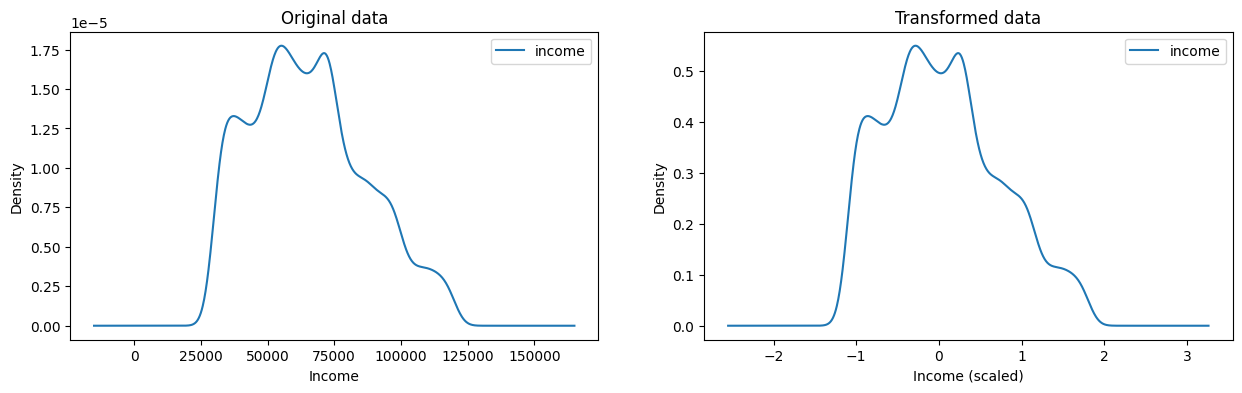

In [93]:
fig, axs = plt.subplots(figsize=(15,4), nrows=1, ncols=2)

income_df.plot.density(ax=axs[0])
axs[0].set_title('Original data')
axs[0].set_xlabel('Income')

data_transformed = robust_scale(income_df)
income_df = pd.DataFrame(data_transformed, columns=income_df.columns, index=income_df.index)

income_df.plot.density(ax=axs[1])
axs[1].set_title('Transformed data')
axs[1].set_xlabel('Income (scaled)')

plt.savefig('figures/income_rescale.png', bbox_inches='tight')
plt.show()

### Explore membership

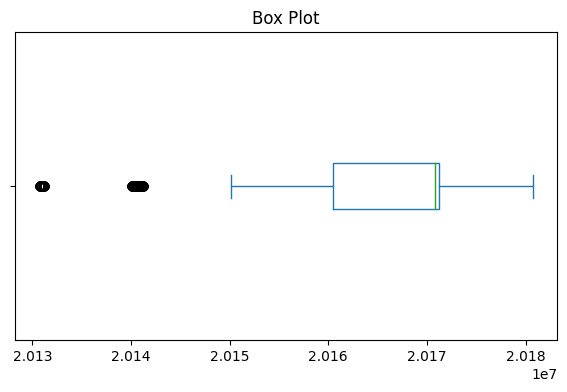

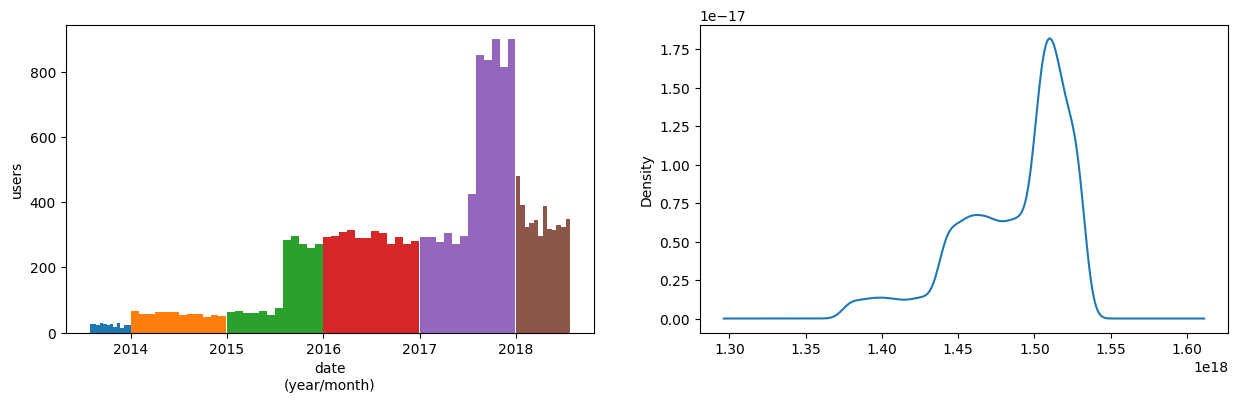

In [94]:
## Select registers
membership_df = profile_df.became_member_on

# Generate box plot
fig1 = plt.figure(figsize=(7,4))
ax = fig1.subplots()
ax.set_title('Box Plot')
membership_df.plot.box(ax=ax, vert=False)
ax.set_yticklabels('')
plt.savefig('figures/explore_membership1.png', bbox_inches='tight')
plt.show()

## Convert data to datetime format
membership_df = pd.to_datetime(membership_df, format='%Y%m%d')

## Generate histograms
bins = 12
fig2, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

membership_df.groupby(membership_df.dt.year) \
    .hist(bins=bins, ax=axs[0])
axs[0].set_ylabel('users')
axs[0].set_xlabel('date\n(year/month)')
axs[0].grid(False)

membership_df.astype(int).plot.density(ax=axs[1])

plt.savefig('figures/explore_membership2.png', bbox_inches='tight')
plt.show()

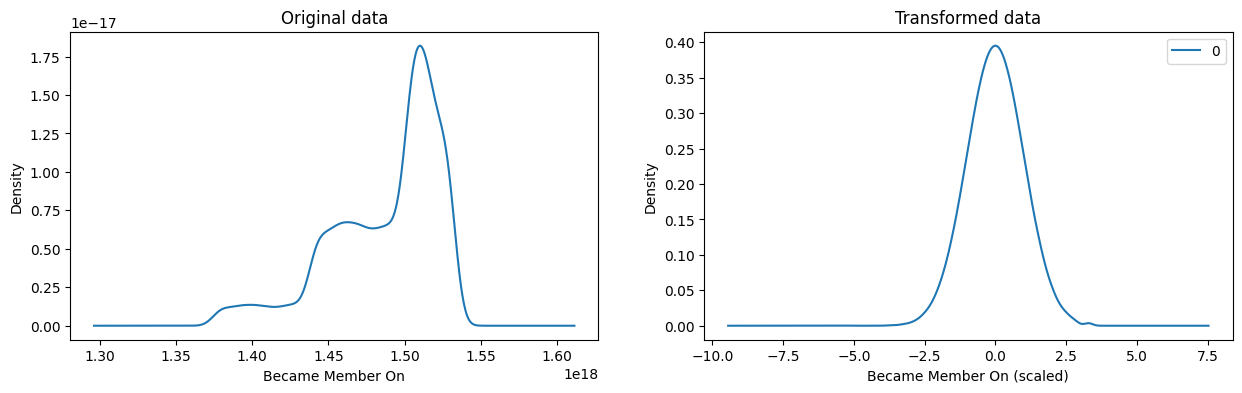

In [96]:
fig, axs = plt.subplots(figsize=(15,4), nrows=1, ncols=2)

membership_values = membership_df.astype(int)
membership_values.plot.density(ax=axs[0])
axs[0].set_title('Original data')
axs[0].set_xlabel('Became Member On')
 
membership_values = quantile_transform(membership_values.values.reshape(-1,1),
                                       output_distribution='normal',
                                       copy=True)
membership_df = pd.DataFrame(membership_values,
                             index=membership_df.index)

membership_df.plot.density(ax=axs[1])
axs[1].set_title('Transformed data')
axs[1].set_xlabel('Became Member On (scaled)')

plt.savefig('figures/membership_rescale.png', bbox_inches='tight')
plt.show()

# Transcript

In [75]:
transcript_df = pd.read_json('data/transcript.json', orient='records', lines=True)
display(transcript_df.head())

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [65]:
print('Missing information')
display(pd.DataFrame(
    {'offer received':
         transcript_df.query('event=="offer received"').isna().all(),
     'offer viewed':
         transcript_df.query('event=="offer viewed"').isna().all(),
     'transaction':
         transcript_df.query('event=="transaction"').isna().all(),
     'offer completed':
         transcript_df.query('event=="offer completed"').isna().all()
    }))

Missing information


,offer received,offer viewed,transaction,offer completed
person,False,False,False,False
event,False,False,False,False
time,False,False,False,False
amount,True,True,False,True
offer_id,False,False,True,False
reward,True,True,True,False


#### Anomalous values

,amount
count,138953.000000
mean,12.777356
std,30.250529
min,0.050000
25%,2.780000
50%,8.890000
75%,18.070000
max,1062.280000


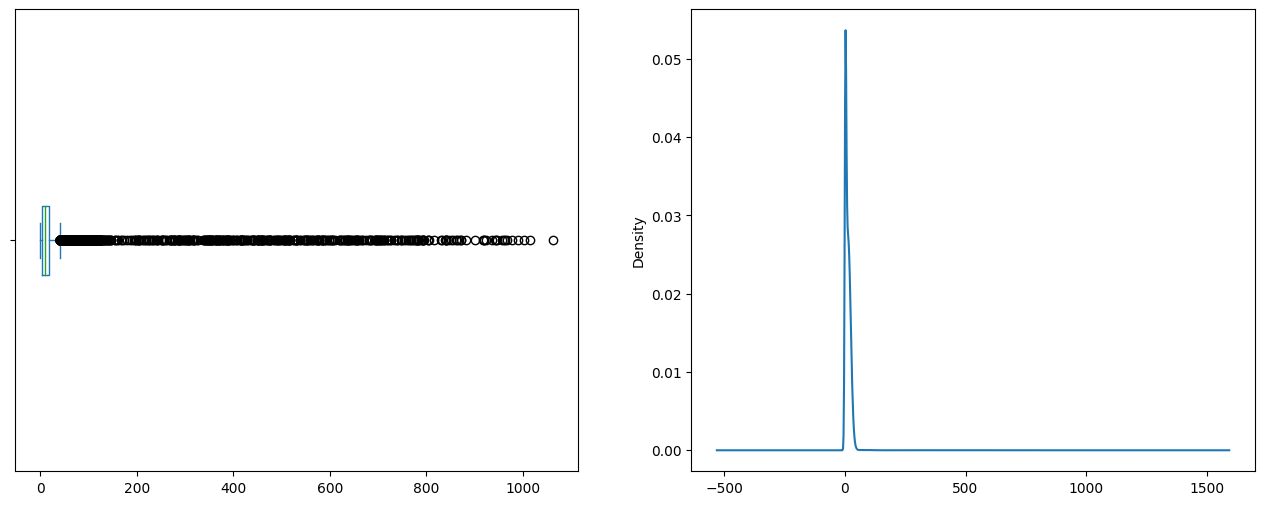

In [72]:
display(pd.DataFrame(transcript_df.amount.describe()))

fig, axs = plt.subplots(figsize=(16,6), nrows=1, ncols=2)

transcript_df.amount.plot.box(ax=axs[0], vert=False)
axs[0].set_yticklabels('')
transcript_df.amount.plot.density(ax=axs[1])
plt.show()

Anomalous values in transactions are so high that they deform completely the plots above.

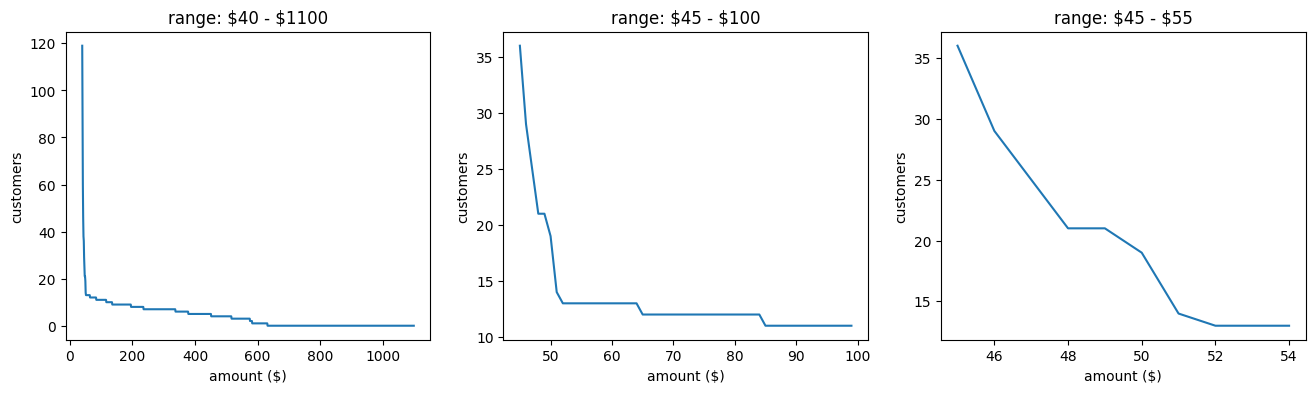

Number of customers with more than 1 transaction with a value >= $50,00: 19
Number of customers with transactions with a value >= $50,00: 687


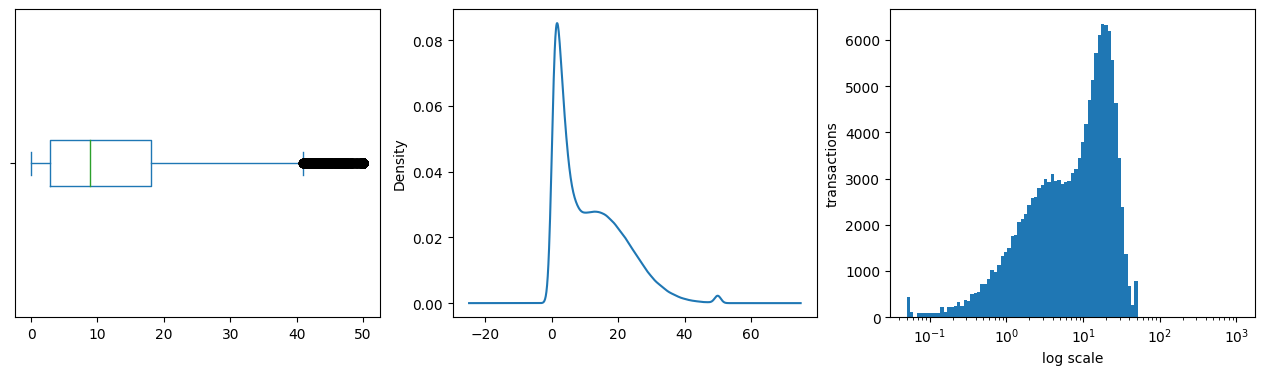

In [73]:
fig, axs = plt.subplots(figsize=(16,4), nrows=1, ncols=3)

n_users = []
values = range(40,1100)
for v in values:
    n_users.append(transcript_df[transcript_df.amount > v] \
                   .person.duplicated().sum())
axs[0].plot(values, n_users)
axs[0].set_title('range: \$40 - \$1100')
axs[0].set_xlabel('amount ($)')
axs[0].set_ylabel('customers')

n_users = []
values = range(45,100)
for v in values:
    n_users.append(transcript_df[transcript_df.amount > v] \
                   .person.duplicated().sum())
axs[1].plot(values, n_users)
axs[1].set_title('range: \$45 - \$100')
axs[1].set_xlabel('amount ($)')
axs[1].set_ylabel('customers')

n_users = []
values = range(45,55)
for v in values:
    n_users.append(transcript_df[transcript_df.amount > v] \
                   .person.duplicated().sum())
axs[2].plot(values, n_users)
axs[2].set_title('range: \$45 - \$55')
axs[2].set_xlabel('amount ($)')
axs[2].set_ylabel('customers')

plt.show()


print('Number of customers with more than 1 transaction with a value >= $50,00:',
       transcript_df[transcript_df.amount >= 50].person.duplicated().sum())
print('Number of customers with transactions with a value >= $50,00:',
       transcript_df[transcript_df.amount >= 50].person.nunique())


fig, axs = plt.subplots(figsize=(16,4), nrows=1, ncols=3)

transcript_df.amount.clip(lower=0.05, upper=50).plot.box(ax=axs[0], vert=False)
axs[0].set_yticklabels('')
transcript_df.amount.clip(lower=0.05, upper=50).plot.density(ax=axs[1])

bins = 100
logbins = np.logspace(np.log10(transcript_df.amount.min().min()),
                      np.log10(transcript_df.amount.max().max()),
                      num=bins)
transcript_df.amount.clip(0.05, 50).hist(bins=logbins, ax=axs[2])
axs[2].set_ylabel('transactions')
axs[2].set_xscale('log')
axs[2].set_xlabel('log scale')
axs[2].grid(False)

plt.show()


The three graphs on the top show the number of customers who repeat a transaction with a value higher than a certain amount. Around the value 50, that number tends to stabilize.  
By setting the threshold to $50, there are 668 customers with transactions higher than this amount, and only 14 of them repeat a similar transaction.  

The three graphs on the bottom present transactions with value clipped to \$50.  